# Agipd geometry

In [2]:
%pylab inline
import condor

Populating the interactive namespace from numpy and matplotlib


### Read CrystFEL geometry generated during previous experiment

In [3]:
import crystfelpy as c
reload(c)
fn_geo = "../geometry/agipd_taw9_oy2_1050addu_hmg5.geom"
det = c.detector.get_detector_geometry(fn_geo)
M = c.detector.calc_mask_image(det, unit_is_pixel=True, label_panels=True)

### Panel arrangement

/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


(-0.5, 1110.5, 1317.5, -0.5)

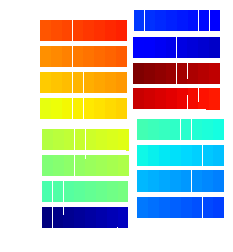

In [4]:
figure()
center_panels = [119, 55, 79, 87]
imshow(M*log10((M>-1)*10), cmap='jet')
axis('off')

### Hole size

In [5]:
# Smallest distance in the center
X, Y, P = c.detector.calc_pixel_coords(det, panel_out=True)
p1 = 87
p2 = 55
X1 = X[P==p1]
Y1 = Y[P==p1]
X2 = X[P==p2]
Y2 = Y[P==p2]
r_min = inf
for x1, y1 in zip(X1, Y1):
    r = sqrt((x1-X2)**2 + (y1-Y2)**2).min()
    if r < r_min:
        r_min = r
print "Hole size: %.1f mm" % round(r_min/1E-3, 1)

Hole size: 12.9 mm


### Condor simulation

Poisson noise
Melbourne virus (200 nm): 178.6 photons


/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


Mimi virus (450 nm): 844.5 photons


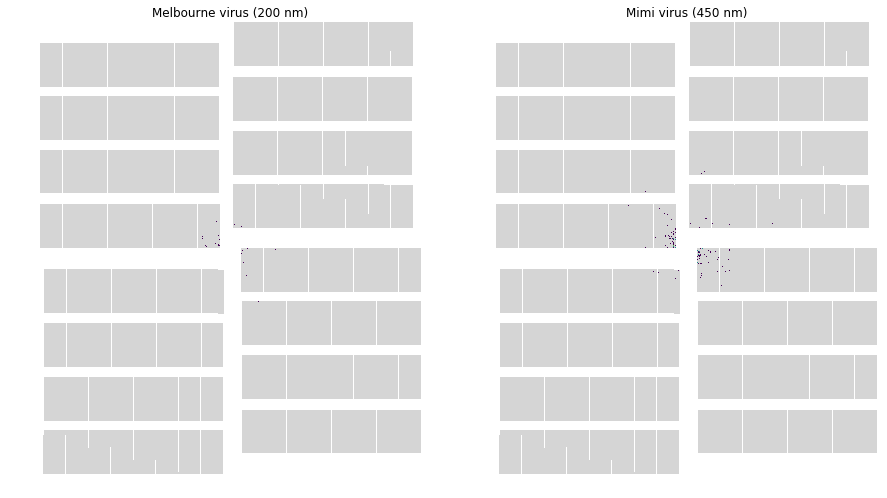

No noise
Melbourne virus (200 nm): 178.6 photons
Mimi virus (450 nm): 844.5 photons


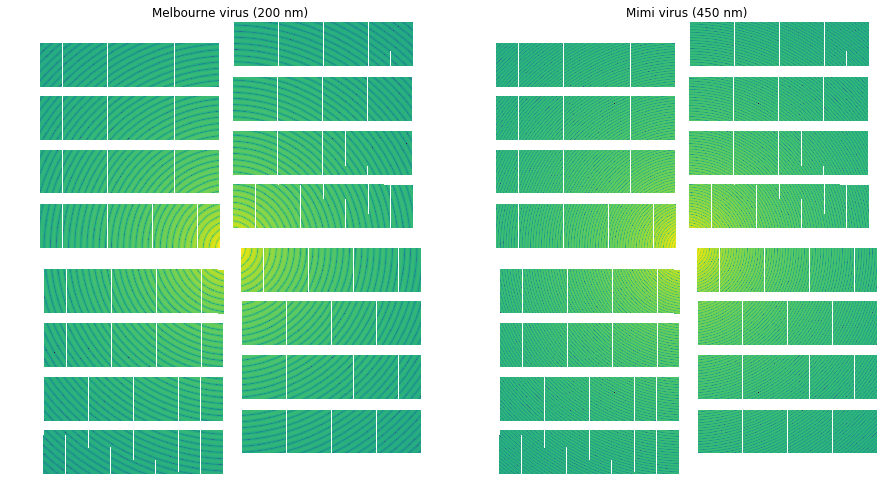

In [12]:
p = condor.utils.photon.Photon(energy_eV=9400.)
src = condor.Source(wavelength=p.get_wavelength(), pulse_energy=0.5E-3, focus_diameter=15E-6)
det = condor.Detector(pixel_size=200E-6, distance=5.4, mask=(M!=-1))

samples = {"Mimi virus (450 nm)": 450E-9, "Melbourne virus (200 nm)": 200E-9,}
noise = {"No noise": lambda inp: inp, "Poisson noise": poisson}

for noise, f in noise.items():
    print noise
    fig, axs = subplots(1, len(samples), figsize=(15, 10))
    for ax, (n, d) in zip(axs, samples.items()):
        #par = {"particle_map": condor.ParticleMap(geometry="icosahedron", diameter=450E-9, material_type="cell")}
        par = {"particle_sphere": condor.ParticleSphere(diameter=d, material_type="cell") }
        E = condor.Experiment(source=src, particles=par, detector=det)
        res = E.propagate()
        img = res["entry_1"]["data_1"]["data"]
        msk = res["entry_1"]["data_1"]["mask"] == 0
        print "%s: %.1f photons" % (n, img[msk].sum())
        ax.set_title(n)
        ax.imshow(log10(msk*10), cmap='binary_r', vmin=0, vmax=1.2)
        ax.imshow(log10(f(img))*log10(msk*10))
        ax.set_axis_off()
    show()
    
